# 03. Pytorch Machine Vision Class

In [3]:
import requests
from pathlib import Path
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_circles
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
import pandas as pd
import torch
from torch import nn
from helper_functions import plot_predictions, plot_decision_boundary, accuracy_fn
from torchmetrics import Accuracy
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from timeit import default_timer as timer
from tqdm.auto import tqdm

c:\Users\Tiger\anaconda3\envs\py311Udemy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Import torch
# import torch

# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Setup random seed
RANDOM_SEED = 42

## get data set

In [5]:
# # set up trainng dta
train_data = datasets.FashionMNIST(
    root = "data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None

    )
# set up test dta
test_data = datasets.FashionMNIST(
    root = "data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None

    )

In [6]:
print(len (train_data), len(test_data))
image, label = train_data[0]
print (image, label)
print (train_data.classes)
print (train_data.class_to_idx)

60000 10000
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0

In [7]:
print(image.shape)
print (train_data.classes[label])

torch.Size([1, 28, 28])
Ankle boot


## visualize

Text(0.5, 1.0, '9')

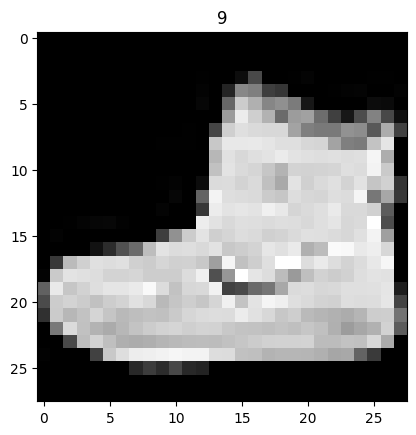

In [8]:
plt.imshow(image.squeeze(), cmap="grey")
plt.title(label)

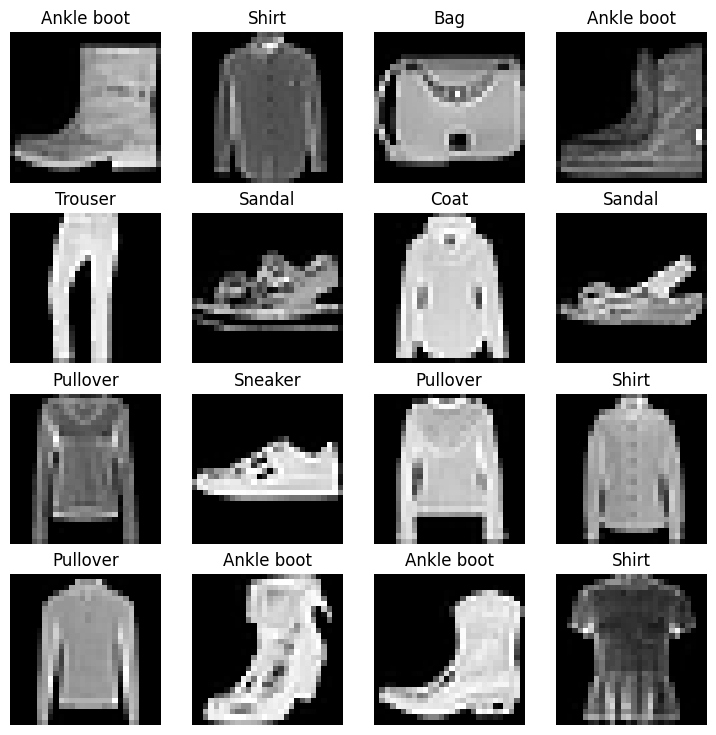

In [9]:
# Show 16 pictures
fig = plt.figure (figsize=(9,9))
rows, cols = 4, 4
for i in range (1, rows*cols + 1):
    img_index = torch.randint(0, len(train_data), size = [1]).item()
    fig.add_subplot (rows, cols, i)
    img, lbl = train_data[img_index]
    plt.imshow(img.squeeze(), cmap = 'grey')
    plt.title(train_data.classes[lbl])
    plt.axis(False)


In [10]:
# turn data into iterable 

In [11]:
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset= train_data,
                              batch_size= BATCH_SIZE,
                              shuffle = True)
test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = False)
print(train_dataloader, test_dataloader)
print (len(train_dataloader), BATCH_SIZE)
print (len (test_dataloader), BATCH_SIZE)


<torch.utils.data.dataloader.DataLoader object at 0x0000026469A05450> <torch.utils.data.dataloader.DataLoader object at 0x00000264698F4490>
1875 32
313 32


In [12]:
# show each batch
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

torch.Size([1, 28, 28])
tensor(8) torch.Size([])


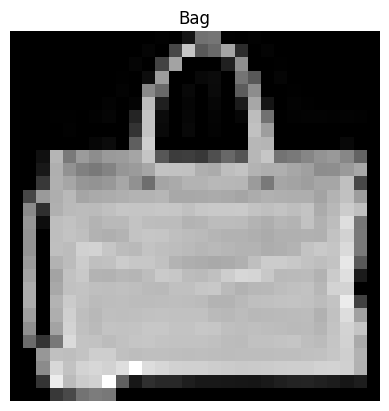

In [13]:
# show sample of 
# torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap = 'grey')
plt.title (train_data.classes[label])
plt.axis(False)
print (img.shape)
print (label, label.shape)

## Baseline Model

In [14]:
# flatten data
flatten_data = nn.Flatten()
x_0 = train_features_batch[0]
x_0_flatten = flatten_data(x_0)
x_0.shape, x_0_flatten.shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [15]:
# first model
class FashionMNISTModelV0(nn.Module):
    def __init__(self,
                 input_shape: int = 784,
                 hidden_units: int = 256,
                 output_shape: int =10):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = input_shape,
                      out_features=hidden_units),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [16]:
# set model
torch.manual_seed(42)
model_0 = FashionMNISTModelV0()
model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [17]:
dummy_x = torch.rand([1,1, 28, 28])
model_0(dummy_x)


tensor([[-0.1632,  0.1134, -0.0667,  0.3176,  0.0384, -0.0599,  0.1459, -0.1255,
          0.1022,  0.2317]], grad_fn=<AddmmBackward0>)

In [18]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [ 0.0307,  0.0202,  0.0212,  ...,  0.0272,  0.0314,  0.0152],
                      [-0.0355,  0.0334, -0.0232,  ...,  0.0185, -0.0292, -0.0017],
                      [-0.0068, -0.0321,  0.0248,  ..., -0.0255, -0.0138, -0.0288]])),
             ('layer_stack.1.bias',
              tensor([ 0.0214, -0.0092,  0.0252,  0.0054, -0.0258, -0.0166, -0.0220, -0.0342,
                      -0.0085,  0.0256, -0.0313, -0.0035,  0.0126,  0.0164,  0.0323, -0.0243,
                       0.0015,  0.0066,  0.0342, -0.0187,  0.0285,  0.0317,  0.0150,  0.0209,
                      -0.0146,  0.0140,  0.0086,  0.0305, -0.0045,  0.0026,  0.0236, -0.0042,
                

In [19]:
# loss functions
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                                                      lr = 0.1)


In [20]:
# time functions
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    total_time = end - start
    print (f'Train time on {device}: {total_time:.3f} seconds')
    return total_time

In [21]:
start_time = timer() 
end_time = timer ()

print_train_time(start_time, end_time, device = 'cpu')

Train time on cpu: 0.000 seconds


3.239998477511108e-05

## use data loader for training


In [22]:
# loop for batch
torch.manual_seed(42)
train_time_start_on_cpu = timer()
epochs = 3
for epoch in tqdm(range(epochs)):
    print (f"Epoch {epoch}\n")
    train_loss = 0
    for batch, (X, y) in enumerate (train_dataloader):
        model_0.train()
        y_pred = model_0(X)

        loss = loss_fn (y_pred, y)
        train_loss += loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if batch % 400 ==0:
            print (f'Batch Number  {batch * len(X)}/{len(train_dataloader.dataset)} samples')

    train_loss /= len(train_dataloader)

    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            test_pred = model_0 (X_test)
            test_loss  += loss_fn(test_pred, y_test)
            test_acc += accuracy_fn(y_true = y_test, y_pred=test_pred.argmax(dim = 1)) 

        test_loss /= len(test_dataloader)
        test_acc /= len (test_dataloader)

    print (f"\nTrain loss: {train_loss:.4f}| test loss: {test_loss:.4f} , Test acc {test_acc:4f}")

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start= train_time_start_on_cpu, 
                                            end = train_time_end_on_cpu,
                                            device = str(next (model_0.parameters()).device))








  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0

Batch Number  0/60000 samples
Batch Number  12800/60000 samples
Batch Number  25600/60000 samples
Batch Number  38400/60000 samples
Batch Number  51200/60000 samples


 33%|███▎      | 1/3 [00:08<00:16,  8.45s/it]


Train loss: 0.5748| test loss: 0.5027 , Test acc 82.517971
Epoch 1

Batch Number  0/60000 samples
Batch Number  12800/60000 samples
Batch Number  25600/60000 samples
Batch Number  38400/60000 samples
Batch Number  51200/60000 samples


 67%|██████▋   | 2/3 [00:16<00:08,  8.35s/it]


Train loss: 0.4739| test loss: 0.4838 , Test acc 82.857428
Epoch 2

Batch Number  0/60000 samples
Batch Number  12800/60000 samples
Batch Number  25600/60000 samples
Batch Number  38400/60000 samples
Batch Number  51200/60000 samples


100%|██████████| 3/3 [00:25<00:00,  8.34s/it]


Train loss: 0.4539| test loss: 0.4763 , Test acc 83.506390
Train time on cpu: 25.027 seconds


In [41]:
# import torch.utils
# import torch.utils.data


torch.manual_seed(42)
def eval_model (model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                accuracy_fn):
    loss, acc = 0,0
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model (X)

            loss += loss_fn (y_pred, y)
            acc += accuracy_fn(y_true = y,
                                y_pred = y_pred.argmax(dim= 1))
        loss /= len (data_loader)
        acc /= len(data_loader)

    return {"mode_name": model.__class__.__name__,
            "model_loss": loss.item(),
            'model_acc': acc}

# model_0_results = eval_model(model = model_0, 
#                              data_loader = test_dataloader,
#                              loss_fn = loss_fn,
#                              accuracy_fn=accuracy_fn)

# model_0_results


    
    

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


## Non Linear model with GPU

In [35]:
# first model
class FashionMNISTModelV1(nn.Module):
    def __init__(self,
                 input_shape: int = 784,
                 hidden_units: int = 256,
                 output_shape: int =10):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = input_shape,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)
    
model_1 = FashionMNISTModelV1().to(device)
model_1

FashionMNISTModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [36]:
# loss functions
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                                                      lr = 0.1)


In [ ]:
# loop for batch
torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print (f"Epoch {epoch}\n")
    train_loss = 0
    for batch, (X, y) in enumerate (train_dataloader):
        model_1.train()
        X, y = X.to(device), y.to(device)
        y_pred = model_1(X)

        loss = loss_fn (y_pred, y)
        train_loss += loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if batch % 400 ==0:
            print (f'Batch Number  {batch * len(X)}/{len(train_dataloader.dataset)} samples')

    train_loss /= len(train_dataloader)

    test_loss, test_acc = 0, 0
    model_1.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            test_pred = model_1 (X_test)
            test_loss  += loss_fn(test_pred, y_test)
            test_acc += accuracy_fn(y_true = y_test, y_pred=test_pred.argmax(dim = 1)) 

        test_loss /= len(test_dataloader)
        test_acc /= len (test_dataloader)

    print (f"\nTrain loss: {train_loss:.4f}| test loss: {test_loss:.4f} , Test acc {test_acc:4f}")

train_time_end_on_cpu = timer()
total_train_time_model_1 = print_train_time(start= train_time_start_on_cpu, 
                                            end = train_time_end_on_cpu,
                                            device = str(next (model_1.parameters()).device))


In [ ]:
# evaluate model 1
model_1_results = eval_model(model = model_1, 
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn=accuracy_fn)

model_1_results

## Functionalze train and test loop


In [65]:
import torch.utils


def train_loop(model: nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              optimizer:torch.optim.Optimizer,
              accuracy_fn,
              device:torch.device= device
              ):
    train_loss = 0
    train_acc = 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_train_pred = model(X)
        loss = loss_fn(y_train_pred, y)
        train_loss += loss
        train_acc  += accuracy_fn(y_true = y, 
                                  y_pred = y_train_pred.argmax (dim = 1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print (f'Train loss: {train_loss:.4f}| Train accuracy: {train_acc:.2f}%')
    

def test_loop (model: nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device:torch.device = device):
    test_loss = 0
    test_acc = 0
    model.eval ()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_test_pred = model(X)
        test_loss += loss_fn(y_test_pred, y)
        test_acc += accuracy_fn(y_true = y,
                                y_pred = y_test_pred.argmax(dim = 1))

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    print (f'Train loss: {test_loss:.5f}| Train Acc {test_acc:.2f}%')    

## call functions to do model 1

In [66]:
torch.manual_seed(42)
train_time_start_on_cpu = timer()

from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print (f"Epoch {epoch}\n")
    train_loop(model=model_1,
               dataloader=train_dataloader,
               loss_fn =loss_fn,
               optimizer = optimizer,
               accuracy_fn=accuracy_fn)
    
    test_loop (model=model_1,
               dataloader= test_dataloader,
               loss_fn = loss_fn,
               accuracy_fn = accuracy_fn)

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0

Train loss: 0.2872| Train accuracy: 89.51%


 33%|███▎      | 1/3 [00:17<00:34, 17.22s/it]

Train loss: 0.34745| Train Acc 87.44%
Epoch 1

Train loss: 0.2803| Train accuracy: 89.69%


 67%|██████▋   | 2/3 [00:33<00:16, 16.83s/it]

Train loss: 0.33771| Train Acc 87.82%
Epoch 2

Train loss: 0.2709| Train accuracy: 89.91%


100%|██████████| 3/3 [00:49<00:00, 16.51s/it]

Train loss: 0.33595| Train Acc 88.08%
Train time on cuda: 49.544 seconds


## test the manual

In [67]:
# evaluate model 1
model_1_results = eval_model(model = model_1, 
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn=accuracy_fn)

model_1_results

{'mode_name': 'FashionMNISTModelV1',
 'model_loss': 0.33595189452171326,
 'model_acc': 88.07907348242811}

## Conv Neural Networks

In [75]:
# create CNN with Tiny VGG
class FashionMNISTModelV2(nn.Module):

    def __init__(self, 
                input_shape: int, 
                hidden_units:int, 
                output_shape: int):
        super().__init__()
        self.conv_block_1= nn.Sequential(
            nn.Conv2d(in_channels = input_shape,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)            
        )
        self.classifer = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_feature = hidden_units*x,
                    out_features=output_shape)

        )

    def forward(self, x):
        x = self.conv_block_1(x)
        print (x.shape)
        x=self.conv_block_2(x)
        print (x.shape)
        return x


        



In [ ]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape = 1,
                              hidden_units = 10,
                              output_shape = len (train_data.classes)).to(device)

### Conv 2d test code

In [77]:
torch.manual_seed(42)

images = torch.randn(size = (32, 3, 64, 64))
test_image = images [0]
print (images.shape)
print(test_image.shape)

torch.Size([32, 3, 64, 64])
torch.Size([3, 64, 64])


In [ ]:
# creates single conv2d
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size = 3,
                       stride=1,
                       padding=0)